# Forecasting Car Collisions 

In [1]:
#Import necessary functions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium


#For Time Series 
from datetime import datetime as dt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/Final_Motor_Vehicle_Collisions_QuBr_2018_2023-Model.csv')
df

,CRASH DATE TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
0,2018-01-01 00:00:00,BROOKLYN,11234,40.628770,-73.918250,1,0,Failure to Yield Right-of-Way,3820945,Sedan,Moving Violation,Winter,Late Night,False
1,2018-01-01 00:05:00,BROOKLYN,11211,40.718460,-73.952810,0,0,Failure to Yield Right-of-Way,3818641,Sedan,Moving Violation,Winter,Late Night,False
2,2018-01-01 00:15:00,BROOKLYN,11236,40.645176,-73.906220,0,0,Unsafe Speed,3824618,Station Wagon/Sport Utility Vehicle,Moving Violation,Winter,Late Night,False
3,2018-01-01 00:30:00,BROOKLYN,11211,40.716805,-73.954600,0,0,Driver Inattention/Distraction,3818640,Taxi,Driver Inattention,Winter,Late Night,False
4,2018-01-01 01:10:00,QUEENS,11385,40.695526,-73.903950,0,0,Traffic Control Disregarded,3819354,Sedan,Moving Violation,Winter,Late Night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42103,2022-12-31 11:37:00,BROOKLYN,11234,40.624560,-73.925545,0,0,Driver Inexperience,4594454,Sedan,Driver Inattention,Winter,Morning,False
42104,2022-12-31 17:25:00,BROOKLYN,11207,40.661026,-73.892480,1,0,Driver Inattention/Distraction,4594225,Sedan,Driver Inattention,Winter,Evening,True
42105,2022-12-31 19:57:00,BROOKLYN,11234,40.613040,-73.926210,1,0,Driver Inattention/Distraction,4596097,Station Wagon/Sport Utility Vehicle,Driver Inattention,Winter,Evening,False
42106,2022-12-31 20:05:00,QUEENS,11101,40.744110,-73.953640,1,0,Driver Inattention/Distraction,4594728,Pick-up Truck,Driver Inattention,Winter,Night,False


In [3]:
#Filter for top two causes
df = df.loc[df['CONTRIBUTING CATEGORY V1'].isin(['Moving Violation', 'Driver Inattention'])]
df

,CRASH DATE TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
0,2018-01-01 00:00:00,BROOKLYN,11234,40.628770,-73.918250,1,0,Failure to Yield Right-of-Way,3820945,Sedan,Moving Violation,Winter,Late Night,False
1,2018-01-01 00:05:00,BROOKLYN,11211,40.718460,-73.952810,0,0,Failure to Yield Right-of-Way,3818641,Sedan,Moving Violation,Winter,Late Night,False
2,2018-01-01 00:15:00,BROOKLYN,11236,40.645176,-73.906220,0,0,Unsafe Speed,3824618,Station Wagon/Sport Utility Vehicle,Moving Violation,Winter,Late Night,False
3,2018-01-01 00:30:00,BROOKLYN,11211,40.716805,-73.954600,0,0,Driver Inattention/Distraction,3818640,Taxi,Driver Inattention,Winter,Late Night,False
4,2018-01-01 01:10:00,QUEENS,11385,40.695526,-73.903950,0,0,Traffic Control Disregarded,3819354,Sedan,Moving Violation,Winter,Late Night,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42103,2022-12-31 11:37:00,BROOKLYN,11234,40.624560,-73.925545,0,0,Driver Inexperience,4594454,Sedan,Driver Inattention,Winter,Morning,False
42104,2022-12-31 17:25:00,BROOKLYN,11207,40.661026,-73.892480,1,0,Driver Inattention/Distraction,4594225,Sedan,Driver Inattention,Winter,Evening,True
42105,2022-12-31 19:57:00,BROOKLYN,11234,40.613040,-73.926210,1,0,Driver Inattention/Distraction,4596097,Station Wagon/Sport Utility Vehicle,Driver Inattention,Winter,Evening,False
42106,2022-12-31 20:05:00,QUEENS,11101,40.744110,-73.953640,1,0,Driver Inattention/Distraction,4594728,Pick-up Truck,Driver Inattention,Winter,Night,False


In [4]:
df_2023 = pd.read_csv('data/Final_Motor_Vehicle_Collisions_QuBr_2023-Future.csv')


df_2023 = df_2023.loc[df_2023['ZIP CODE'].isin(top10zips_mv)]

#Filter for top two causes
df_2023 = df_2023.loc[df_2023['CONTRIBUTING CATEGORY V1'].isin(['Moving Violation', 'Driver Inattention'])]
df_2023

NameError: name 'top10zips_mv' is not defined

#### Changing DateTime Index

In [5]:
#Change column to datetime datatype
df['CRASH DATE TIME'] = pd.to_datetime(df['CRASH DATE TIME'])
df_2023['CRASH DATE TIME'] = pd.to_datetime(df_2023['CRASH DATE TIME'])

In [6]:
ts = df.copy()
ts_2023 = df_2023.copy()
ts.head()

,CRASH DATE TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1,CONTRIBUTING CATEGORY V1,SEASON,TIME OF DAY,IS RUSH HOUR
0,2018-01-01 00:00:00,BROOKLYN,11234,40.628770,-73.91825,1,0,Failure to Yield Right-of-Way,3820945,Sedan,Moving Violation,Winter,Late Night,False
1,2018-01-01 00:05:00,BROOKLYN,11211,40.718460,-73.95281,0,0,Failure to Yield Right-of-Way,3818641,Sedan,Moving Violation,Winter,Late Night,False
2,2018-01-01 00:15:00,BROOKLYN,11236,40.645176,-73.90622,0,0,Unsafe Speed,3824618,Station Wagon/Sport Utility Vehicle,Moving Violation,Winter,Late Night,False
3,2018-01-01 00:30:00,BROOKLYN,11211,40.716805,-73.95460,0,0,Driver Inattention/Distraction,3818640,Taxi,Driver Inattention,Winter,Late Night,False
4,2018-01-01 01:10:00,QUEENS,11385,40.695526,-73.90395,0,0,Traffic Control Disregarded,3819354,Sedan,Moving Violation,Winter,Late Night,False


### Groupby Daily

In [7]:
#Group the values by day and count the number of instances of each value
daily_count = ts.groupby([ts['CRASH DATE TIME'].dt.date, 'CONTRIBUTING CATEGORY V1']).size().reset_index(name='count')
daily2023_count = ts_2023.groupby([ts_2023['CRASH DATE TIME'].dt.date, 'CONTRIBUTING CATEGORY V1']).size().reset_index(name='count')

#Print the result
print(daily_count)

     CRASH DATE TIME CONTRIBUTING CATEGORY V1  count
0         2018-01-01       Driver Inattention      9
1         2018-01-01         Moving Violation     17
2         2018-01-02       Driver Inattention     11
3         2018-01-02         Moving Violation     13
4         2018-01-03       Driver Inattention     12
...              ...                      ...    ...
3640      2022-12-29         Moving Violation      9
3641      2022-12-30       Driver Inattention     10
3642      2022-12-30         Moving Violation      6
3643      2022-12-31       Driver Inattention      8
3644      2022-12-31         Moving Violation      5

[3645 rows x 3 columns]


In [8]:
#Create pivot table of daily cause categories
ts_pivt = daily_count.pivot(index='CRASH DATE TIME', columns='CONTRIBUTING CATEGORY V1', values='count').fillna(0)
ts2023_pivt = daily2023_count.pivot(index='CRASH DATE TIME', columns='CONTRIBUTING CATEGORY V1', values='count').fillna(0)


ts_pivt.head(10)

CONTRIBUTING CATEGORY V1,Driver Inattention,Moving Violation
CRASH DATE TIME,,
2018-01-01,9.0,17.0
2018-01-02,11.0,13.0
2018-01-03,12.0,19.0
2018-01-04,6.0,6.0
2018-01-05,10.0,26.0
2018-01-06,12.0,22.0
2018-01-07,11.0,18.0
2018-01-08,11.0,26.0
2018-01-09,14.0,29.0


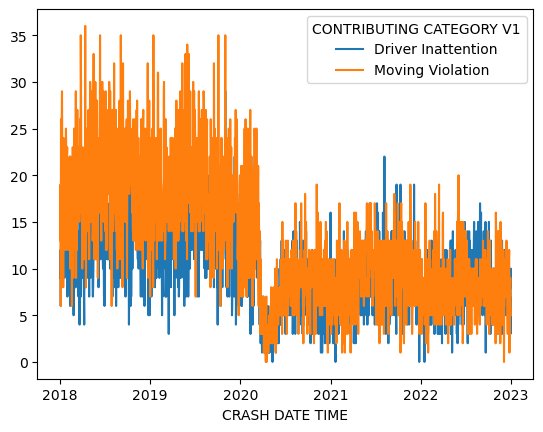

In [9]:
ts_pivt.plot();

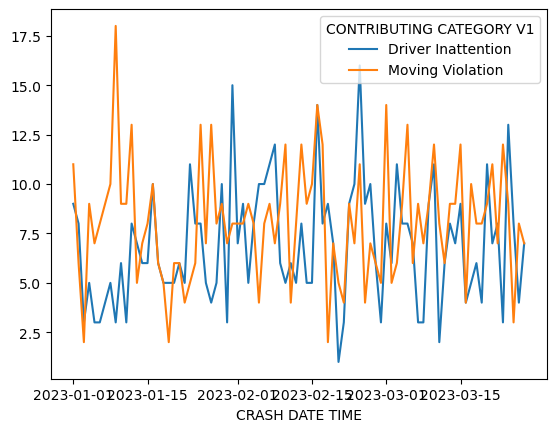

In [10]:
ts2023_pivt.plot();

In [11]:
#Converting the index as datetime index
ts_pivt.index = pd.to_datetime(ts_pivt.index)
ts2023_pivt.index = pd.to_datetime(ts2023_pivt.index)

In [12]:
ts_pivt

CONTRIBUTING CATEGORY V1,Driver Inattention,Moving Violation
CRASH DATE TIME,,
2018-01-01,9.0,17.0
2018-01-02,11.0,13.0
2018-01-03,12.0,19.0
2018-01-04,6.0,6.0
2018-01-05,10.0,26.0
...,...,...
2022-12-27,2.0,8.0
2022-12-28,7.0,9.0
2022-12-29,3.0,9.0


In [24]:
#Select highest causes of collision
ts_mv = ts_pivt[['Moving Violation']]
ts_di = ts_pivt[['Driver Inattention']]

ts_di

CONTRIBUTING CATEGORY V1,Driver Inattention
CRASH DATE TIME,
2018-01-01,9.0
2018-01-02,11.0
2018-01-03,12.0
2018-01-04,6.0
2018-01-05,10.0
...,...
2022-12-27,2.0
2022-12-28,7.0
2022-12-29,3.0


In [25]:
#
ts2023_mv = ts2023_pivt[['Moving Violation']]
ts2023_di = ts2023_pivt[['Driver Inattention']]

ts2023_di

CONTRIBUTING CATEGORY V1,Driver Inattention
CRASH DATE TIME,
2023-01-01,9
2023-01-02,8
2023-01-03,3
2023-01-04,5
2023-01-05,3
...,...
2023-03-23,3
2023-03-24,13
2023-03-25,8


## Stationarity
Before we can begin modeling, we must check the stationarity of the dataset. A stationary dataset is required for Time Series models to perform well and accurately. The Dickey-Fuller statistical test will be utilized to verify stationarity.

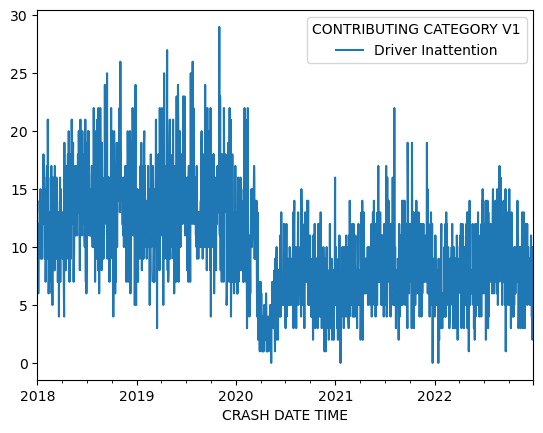

In [26]:
ts_di.plot();

In [27]:
from statsmodels.tsa.stattools import adfuller

vtest = adfuller(ts_di)
vtest

(-2.338436883011533,
 0.15987072000573593,
 25,
 1800,
 {'1%': -3.4339881389288407,
  '5%': -2.863147035877915,
  '10%': -2.567625533641975},
 9701.43743015893)

In [28]:
p_val = adfuller(ts_di)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" therefore we can safely assume that the data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.15987072000573593,
 therefore we cannot reject the null hypothesis that the data is not stationary.


## Decomposition

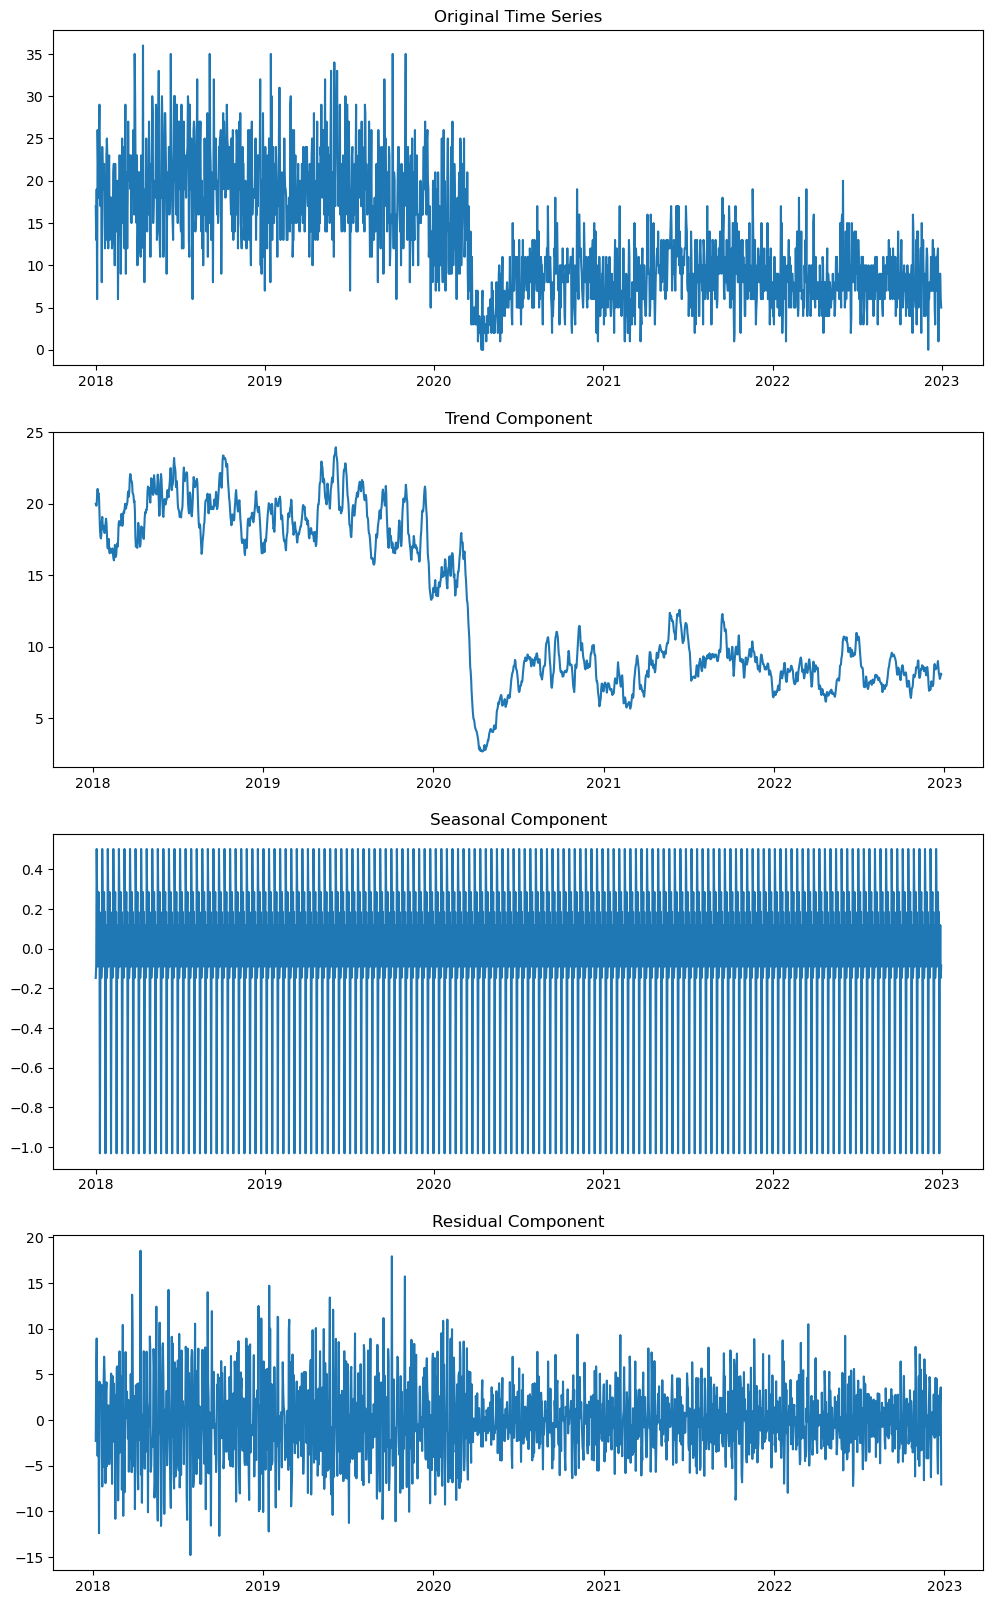

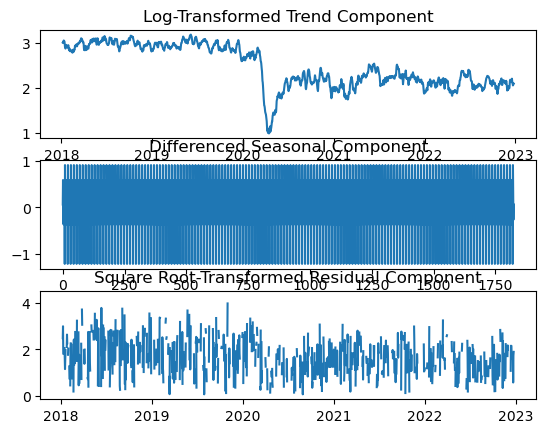

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose


fig = plt.figure(figsize=(12, 20))

# Apply decomposition to separate the time series into trend, seasonal, and residual components
decomp = seasonal_decompose(ts_mv['Moving Violation'], model='additive', period=12) # Change period according to seasonality

# Plot the original time series and the decomposed components
plt.subplot(4, 1, 1)
plt.plot(ts_mv['Moving Violation'])
plt.title('Original Time Series')

plt.subplot(4, 1, 2)
plt.plot(decomp.trend)
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(decomp.seasonal)
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(decomp.resid)
plt.title('Residual Component')

# Apply different transformations to each component
trend_transformed = np.log(decomp.trend)
seasonal_transformed = np.diff(decomp.seasonal, n=1)
residual_transformed = np.sqrt(decomp.resid)

# Plot the transformed components
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(trend_transformed)
plt.title('Log-Transformed Trend Component')

plt.subplot(3, 1, 2)
plt.plot(seasonal_transformed)
plt.title('Differenced Seasonal Component')

plt.subplot(3, 1, 3)
plt.plot(residual_transformed)
plt.title('Square Root-Transformed Residual Component')

plt.show()

### Differencing
To make the dataset stationary, we will be differencing the data. 

In [29]:
#Difference the data and drop the NaN values
diff = ts_di.diff().dropna()

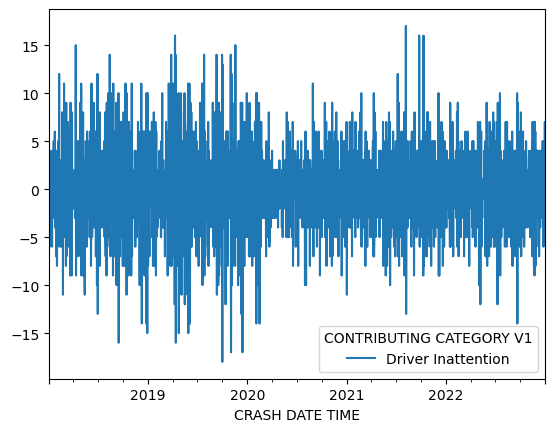

In [30]:
diff.plot();

The first differencing of the data looks to have removed the strong trend within the dataset and looks like it is stationary, however, we will double check the stationarity with the Dickey-Fuller statistical test. 

In [31]:
#Dickey-Fuller test to verify stationarity
difftest = adfuller(diff)
difftest

(-13.88134894919307,
 6.202808846421239e-26,
 23,
 1801,
 {'1%': -3.4339861159726306,
  '5%': -2.863146142843122,
  '10%': -2.5676250581282964},
 9699.660127523492)

In [32]:
#Sanity check to confirm stationarity
diff_pval = adfuller(diff)[1]

print(f"The p-value associated with the Dickey-Fuller statistical test is {diff_pval},")
if diff_pval < 0.05:
    print(" therefore we can safely assume that subtracted rolling mean data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that subtracted rolling mean data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 6.202808846421239e-26,
 therefore we can safely assume that subtracted rolling mean data is stationary.


## Train Test Split

In [33]:
# find the index which allows us to split off 20% of the data
cutoff = round(ts_di.shape[0]*0.8) #cut off point at 80% of the data
cutoff

1461

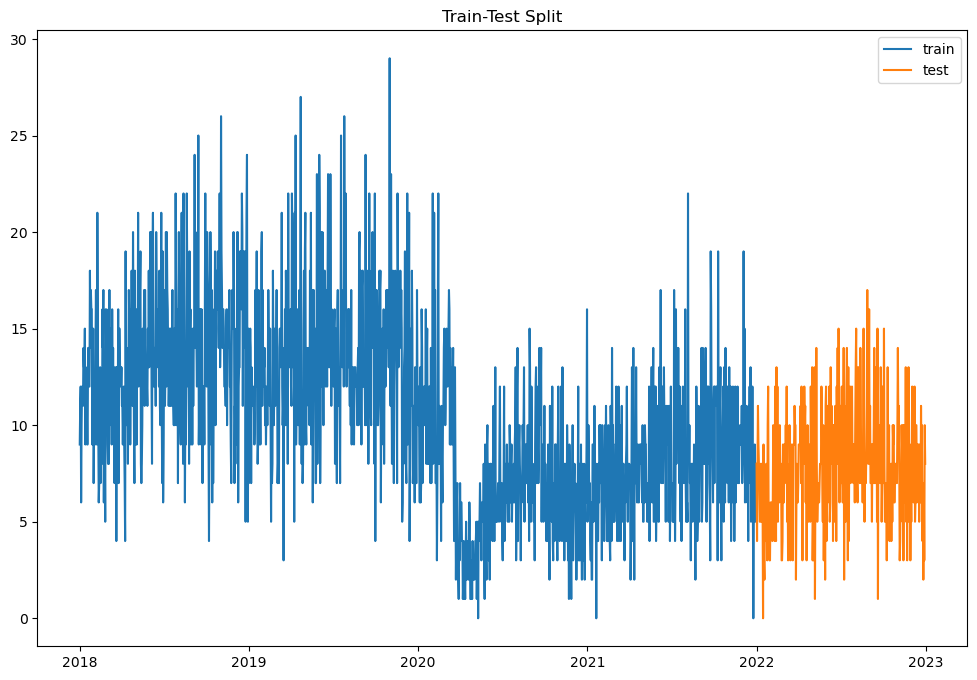

In [34]:
# Define train and test sets according to the index found above
train = ts_di[:cutoff] #before cut off is train set -- 80%

test = ts_di[cutoff:] #after cut off is the test set --20%

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

Source: https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

# Baseline Model
The baseline model is a naive model, which is just one shift in time by one period in time and in this case, it would be by 1 week. The metric that will be used to determine the quality and effectiveness of the model will be Root Mean Squared Error (RMSE). 

In [35]:
#
baseline = train.copy()
baseline['One Shift'] = train.shift(1)
baseline

CONTRIBUTING CATEGORY V1,Driver Inattention,One Shift
CRASH DATE TIME,,
2018-01-01,9.0,NaN
2018-01-02,11.0,9.0
2018-01-03,12.0,11.0
2018-01-04,6.0,12.0
2018-01-05,10.0,6.0
...,...,...
2021-12-27,8.0,5.0
2021-12-28,9.0,8.0
2021-12-29,5.0,9.0


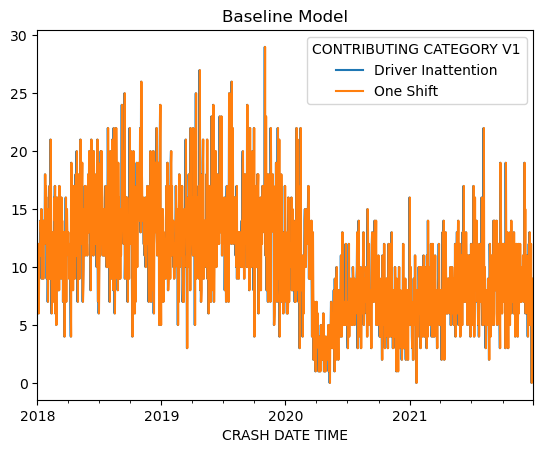

In [36]:
#
baseline.plot()
plt.title('Baseline Model');

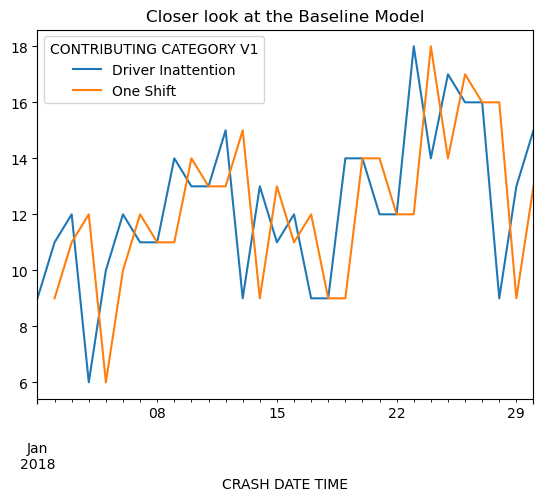

In [37]:
#A closer look
baseline[0:30].plot()
plt.title('Closer look at the Baseline Model');

In [39]:
#Calculate the Root Mean Square Error of the baseline model
baseline_rmse = np.sqrt(mean_squared_error(baseline['Driver Inattention'][1:], baseline['One Shift'].dropna()))

print(f'Baseline Model RMSE: {baseline_rmse}')

Baseline Model RMSE: 4.974455294748567


## First Simple Model - ARIMA

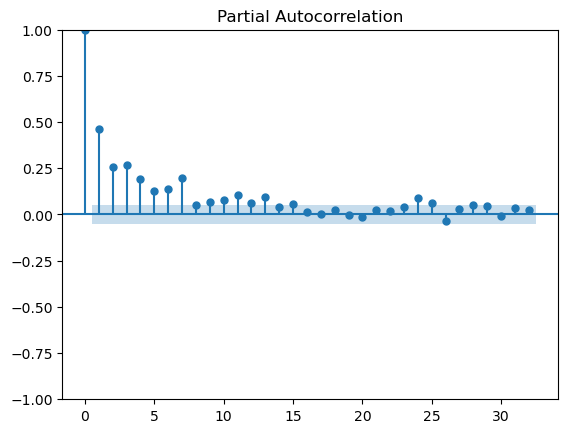

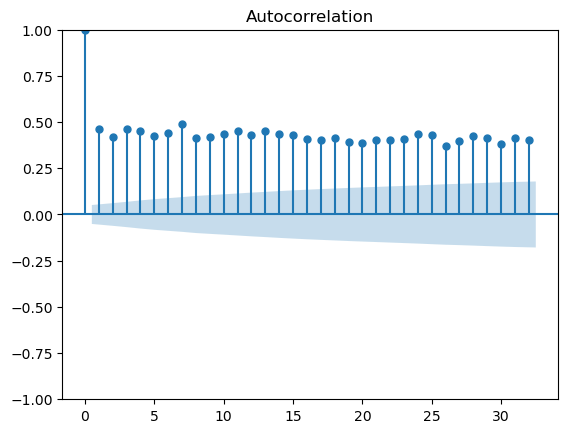

In [40]:
##plot_acf is used to identify the p parameter 
plot_pacf(train)

#Plot_acf is used to identify the q parameter
plot_acf(train);

p = 1 and q = 1

In [43]:
#ARIMA model 
model1 = ARIMA(train['Driver Inattention'], order=(1, 1, 1)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Driver Inattention   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3980.895
Date:                Mon, 17 Apr 2023   AIC                           7967.790
Time:                        22:38:49   BIC                           7983.649
Sample:                    01-01-2018   HQIC                          7973.706
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0317      0.026      1.198      0.231      -0.020       0.084
ma.L1         -0.9321      0.011    -86.507      0.000      -0.953      -0.911
sigma2        13.6542      0.454     30.046      0.000      12.763      14.545
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                42.21
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred1 = model1.predict(typ='levels')

#Calculate the Root Mean Square Error
rmse_model1 = np.sqrt(mean_squared_error(train, train_pred1))

print(f'First Model RMSE: {rmse_model1}')

First Model RMSE: 3.702425501684514


In [ ]:
#Generate predictions for the test set
df_pred = model1.predict(start='2022-01-09', end='2023-01-01')

# plot actual vs. predicted
fig = plt.figure(figsize=(12, 8))
plt.title('ARIMA Predictions')
plt.plot(train, label='actual train')
plt.plot(test, label='actual test')
plt.plot(df_pred, label='predicted test');
plt.legend();

In [ ]:
#Forecast future predictions onto the dataset
forecast_test = model1.forecast(len(test))
ts_mv1=ts_mv.copy()
ts_mv1['Forecast'] = [None]*len(train) + list(forecast_test)

ts_mv1.plot();

Flat lining result confirms that there is seasonality within the data. With the seasonality, it is best to use a SARIMA or SARIMAX model. 

## Second Model - SARIMA using Auto ARIMA
Code Source: https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b

In [33]:
from tqdm import tqdm_notebook

def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [34]:
from itertools import product

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [35]:
params2 = optimize_SARIMA(parameters_list, 1, 1, 7, ts_mv['Moving Violation'])
params2

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 1)",10439.401855
1,"(1, 1, 0, 1)",10439.700897
2,"(0, 2, 1, 2)",10440.364451
3,"(1, 1, 1, 2)",10440.675110
4,"(1, 2, 0, 1)",10440.964001
...,...,...
251,"(3, 0, 0, 0)",11874.451486
252,"(2, 0, 0, 0)",11984.574942
253,"(0, 0, 1, 0)",12057.695121
254,"(1, 0, 0, 0)",12217.975882


In [36]:
model2 = SARIMAX(train['Moving Violation'], order=(0, 1, 2), seasonal_order=(0, 1, 1, 7)).fit(dis=-1)
model2.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04778D+00    |proj g|=  6.93186D-02

At iterate    5    f=  2.91165D+00    |proj g|=  7.12880D-03

At iterate   10    f=  2.90868D+00    |proj g|=  7.14230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   9.229D-06   2.909D+00
  F =   2.9086775334205326     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    Moving Violation   No. Observations:                 1461
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -4249.578
Date:                             Sun, 16 Apr 2023   AIC                           8507.156
Time:                                     01:11:57   BIC                           8528.281
Sample:                                 01-01-2018   HQIC                          8515.038
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8356      0.024    -35.050      0.000      -0.882      -0.789
ma.L2         -0.0782      0.024     -3.241      0.001      -0.125      -0.031
ma.S.L7       -0.9657      0.009   -107.863      0.000      -0.983      -0.948
sigma2        20.0099      0.687     29.115      0.000      18.663      21.357
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.45
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

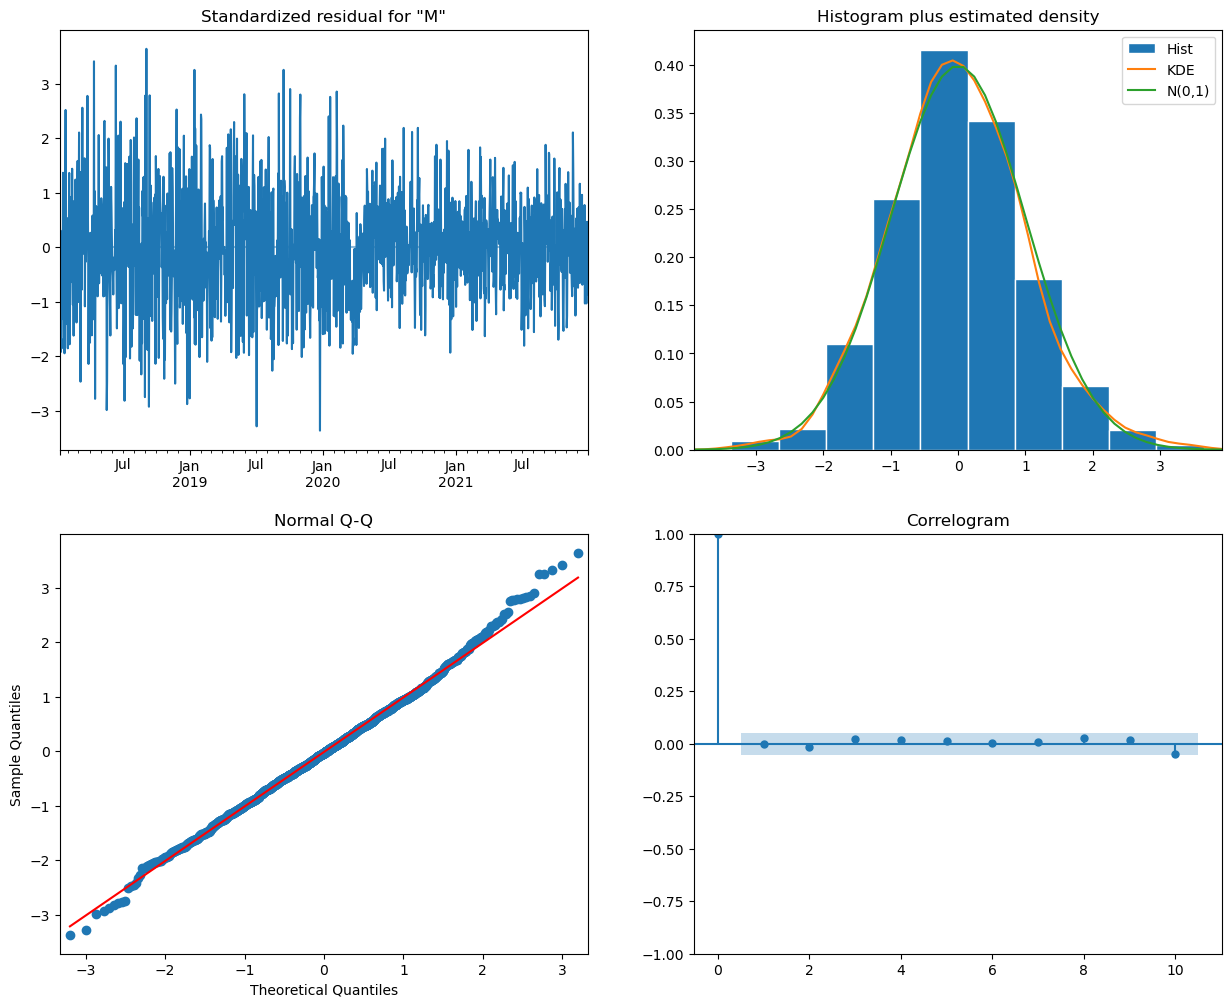

In [37]:
model2.plot_diagnostics(figsize=(15,12));

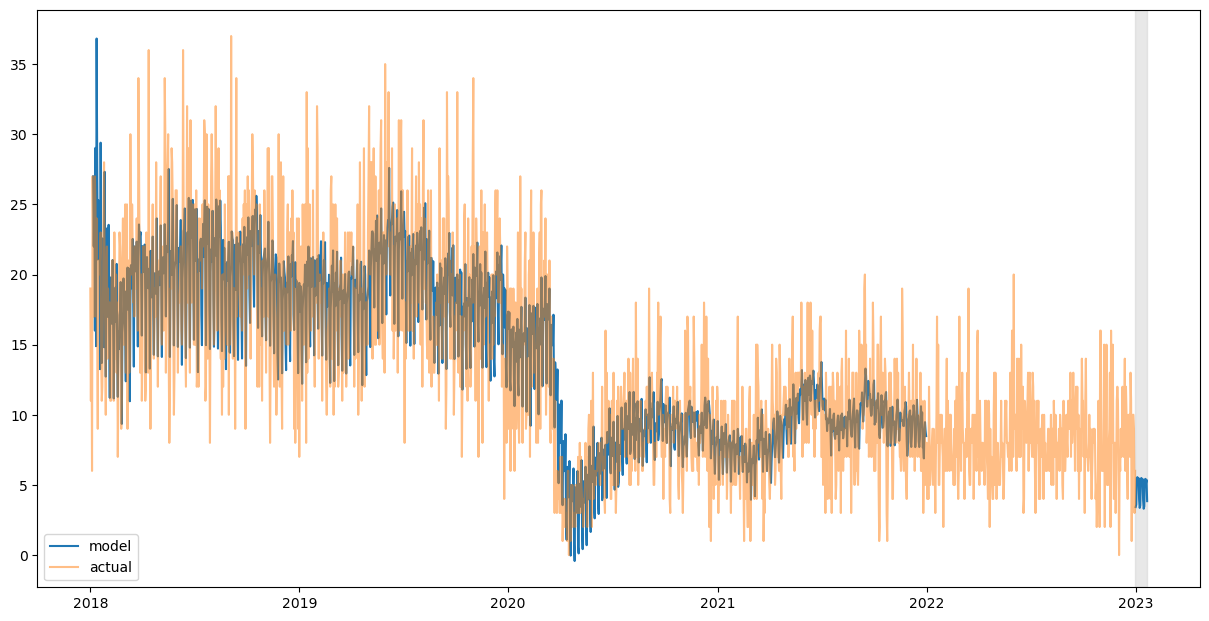

In [38]:
ts_mv['arima_model'] = model2.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast = model2.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast = ts_mv['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, label='model')
plt.axvspan(ts_mv.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
#plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.legend()
plt.show()

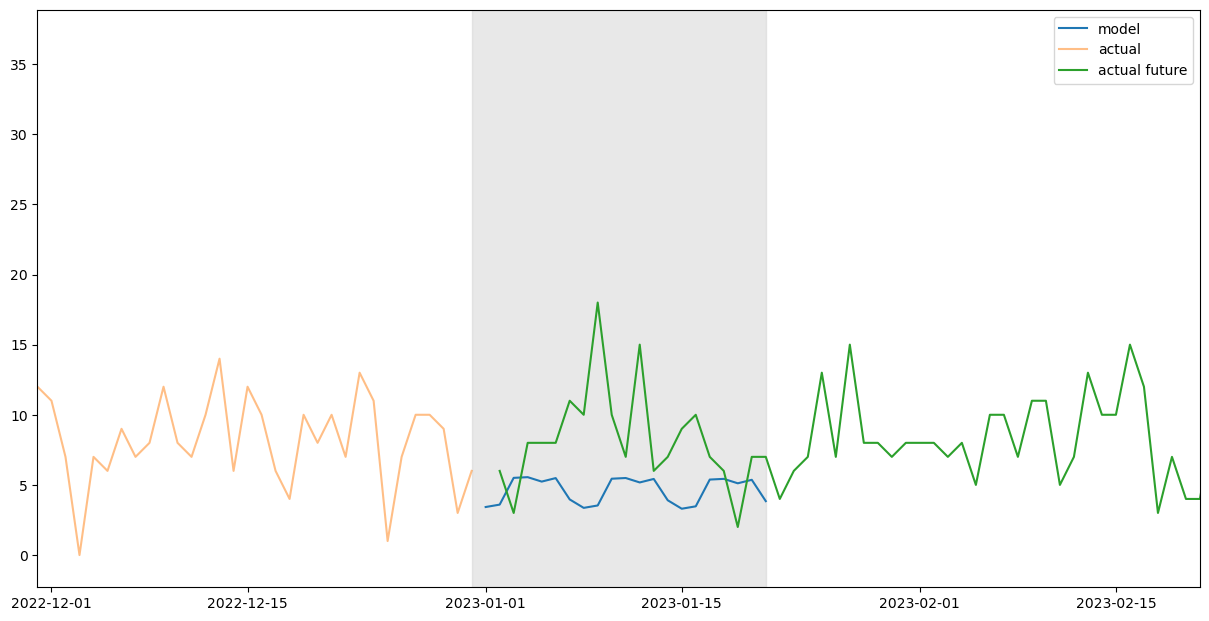

In [39]:
#Closer look

ts_mv['arima_model'] = model2.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast = model2.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast = ts_mv['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, label='model')
plt.axvspan(ts_mv.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.xlim(ts_mv.index[-1] - pd.DateOffset(months=1), forecast.index[-1] + pd.DateOffset(months=1))
plt.legend()
plt.show();

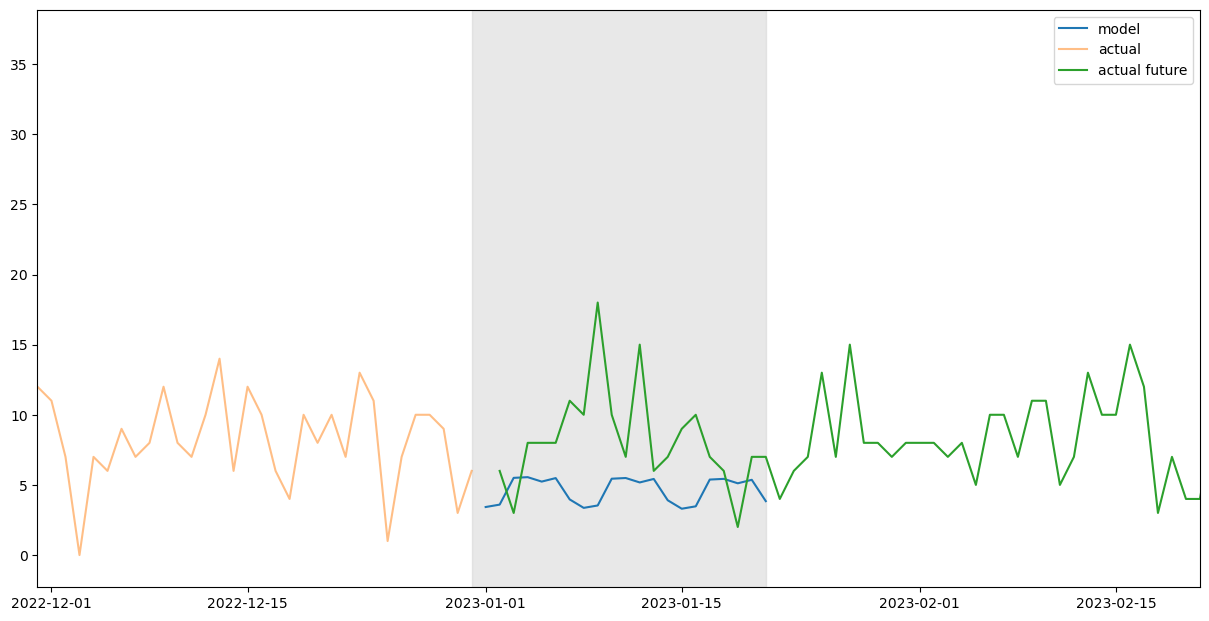

In [40]:
#Closer look

ts_mv['arima_model'] = model2.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast = model2.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast = ts_mv['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, label='model')
plt.axvspan(ts_mv.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.xlim(ts_mv.index[-1] - pd.DateOffset(months=1), forecast.index[-1] + pd.DateOffset(months=1))
plt.legend()
plt.show();

In [41]:
train2_pred = forecast.dropna()
train2_pred = train2_pred[:'2023-01-05']
train2_pred

2018-01-06    26.999425
2018-01-07    22.000215
2018-01-08    26.500123
2018-01-09    16.000618
2018-01-10    29.028347
                ...    
2023-01-01     3.424636
2023-01-02     3.595650
2023-01-03     5.503369
2023-01-04     5.553083
2023-01-05     5.237205
Length: 1461, dtype: float64

In [42]:
#
rmse_model2 = np.sqrt(mean_squared_error(train, train2_pred))

print(f'Second Model RMSE: {rmse_model2}')

Second Model RMSE: 5.22860326224159


In [43]:
print(f'Baseline Model RMSE: {baseline_rmse}')
print(f'First Model RMSE: {rmse_model1}')
print(f'Second Model RMSE: {rmse_model2}')

Baseline Model RMSE: 6.167912992652499
First Model RMSE: 4.777718879261387
Second Model RMSE: 5.22860326224159


In [44]:
from itertools import product

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


## Third Model

In [45]:
import itertools
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[5]))


Examples of parameter combinations for Seasonal ARIMA:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
SARIMAX: (0, 1, 1) x (1, 0, 1, 12)


In [46]:
metric_aic_dict = dict()

for pm in pdq:
    for pm_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train,
                           order=pm,
                           seasonal_order=pm_seasonal,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
            model_aic = model.fit()
            print('ARIMA {} x {} - AIC:{}'.format(pm, pm_seasonal, model_aic.aic))
            metric_aic_dict.update({(pm, pm_seasonal):model_aic.aic})
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18633D+00    |proj g|=  1.78884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   8.200D-07   4.186D+00
  F =   4.1863321487571605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 0, 12) - AIC:12234.462538668424
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variab

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA (0, 0, 0) x (0, 0, 1, 12) - AIC:11086.649686309556
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31253D+00    |proj g|=  1.29711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.637D-07   3.313D+00
  F =   3.3125139161953872     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 0, 12) - AIC:9681.165663122922
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =  

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.03584D+00    |proj g|=  3.78769D-02

At iterate   10    f=  3.03269D+00    |proj g|=  1.13630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     13      1     0     0   2.616D-08   3.033D+00
  F =   3.0326889826793737     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 12) - AIC:8865.51720738913
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28818D+00    |proj g|=  2.86501D-05

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.07274D+00    |proj g|=  2.47932D+00

At iterate   10    f=  3.05752D+00    |proj g|=  1.99071D-01

At iterate   15    f=  3.05727D+00    |proj g|=  2.34066D-03

At iterate   20    f=  3.05725D+00    |proj g|=  5.24274D-02

At iterate   25    f=  3.05723D+00    |proj g|=  1.06598D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     31      1     0     0   4.294D-08   3.057D+00
  F =   3.0572299351125465     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 0, 1, 12) - AIC:8939.225870398861
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.03445D+00    |proj g|=  3.81399D-02

At iterate   10    f=  3.03272D+00    |proj g|=  7.32564D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     21      1     0     0   2.340D-05   3.032D+00
  F =   3.0324132491363720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 1, 1, 12) - AIC:8866.71151397648
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94412D+00    |proj g|=  2.74763D-01

At iterate    

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  3.78091D+00    |proj g|=  2.21054D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     29      1     0     0   1.047D-05   3.781D+00
  F =   3.7807093301319949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 0, 0, 12) - AIC:11051.232662645689
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89216D+00    |proj g|=  3.77217D-01

At iterate    5    f=  3.74717D+00    |proj g|=  1.30991D-01

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.29877D+00    |proj g|=  1.58451D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.585D-07   3.299D+00
  F =   3.2987663448035582     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 1, 0, 12) - AIC:9642.995259515998
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07407D+00    |proj g|=  1.08303D-01

At iterate    5    f=  3.01675D+00    |proj g|=  1.29023D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  3.26809D+00    |proj g|=  2.25485D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   1.865D-05   3.268D+00
  F =   3.2679697088384438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 0, 0, 12) - AIC:9555.007489225933
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71247D+00    |proj g|=  1.04501D+00


 This problem is unconstrained.



At iterate    5    f=  3.69681D+00    |proj g|=  1.59353D-01

At iterate   10    f=  3.43143D+00    |proj g|=  5.13840D-01

At iterate   15    f=  3.18526D+00    |proj g|=  6.11336D-01

At iterate   20    f=  3.02782D+00    |proj g|=  1.18150D-01

At iterate   25    f=  3.02772D+00    |proj g|=  1.24985D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     56      1     0     0   1.250D-04   3.028D+00
  F =   3.0277193969066838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 0, 1, 12) - AIC:8854.99607776133
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15436D+00    |proj g|=  3.57441D-02

At iterate    5    f=  3.13644D+00    |proj g|=  4.11933D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.



At iterate    5    f=  3.03147D+00    |proj g|=  8.00933D-02

At iterate   10    f=  3.00338D+00    |proj g|=  7.82706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     36      1     0     0   1.465D-05   3.003D+00
  F =   3.0033705609546568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 1, 12) - AIC:8783.848779109507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23363D+00    |proj g|=  3.48770D-05

           * 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20124D+00    |proj g|=  4.33820D-02

At iterate    5    f=  3.20019D+00    |proj g|=  4.50795D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   4.508D-07   3.200D+00
  F =   3.2001916267904202     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (0, 0, 1, 12) - AIC:9354.959933481608
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29625D+00    |proj g|=  2.15477D-01

At iterate    5    f=  3.24463D+00    |proj g|=  1.37771D-01

At iterate   10    f=  3.19599D+00    |proj g|=  9.29686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     18      1     0     0   2.605D-05   3.196D+00
  F =   3.1959507447851507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 1, 12) - AIC:9342.56807626221
RUNNING THE L-B

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     16      1     0     0   9.689D-07   3.200D+00
  F =   3.1996855367111352     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 0, 1, 12) - AIC:9355.481138269937
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39891D+00    |proj g|=  6.71068D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33978D+00    |proj g|=  1.60101D-01

At iterate    5    f=  3.22236D+00    |proj g|=  4.04519D-02

At iterate   10    f=  3.19259D+00    |proj g|=  8.81805D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     22      1     0     0   1.944D-05   3.193D+00
  F =   3.1925530676930363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 1, 12) - AIC:9334.640063799052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.94373D+00    |proj g|=  1.22233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   5.254D-06   2.944D+00
  F =   2.9437256122831212     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 12) - AIC:8607.56623909128
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39571D+00    |proj g|=  2.39592D-01
  ys=-1.564E-02  -gs= 2.540E-02 BFGS update SKIPPED


 This problem is unconstrained.



At iterate    5    f=  3.31230D+00    |proj g|=  2.54922D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     23      1     1     0   2.867D-04   3.311D+00
  F =   3.3105392453524094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 0, 12) - AIC:9677.39567491974
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15848D+00    |proj g|=  1.63566D-01


 This problem is unconstrained.



At iterate    5    f=  3.07395D+00    |proj g|=  7.61778D-02

At iterate   10    f=  2.94459D+00    |proj g|=  1.96115D-01

At iterate   15    f=  2.94016D+00    |proj g|=  3.65094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   9.884D-06   2.940D+00
  F =   2.9401609328087059     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 1, 1, 12) - AIC:8597.150245667039
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  2.95391D+00    |proj g|=  5.88190D-02

At iterate   10    f=  2.94895D+00    |proj g|=  3.52829D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   6.920D-06   2.949D+00
  F =   2.9489467894767021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (1, 0, 0, 12) - AIC:8622.822518850924
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00558D+00    |proj g|=  2.40772D-01


 This problem is unconstrained.



At iterate    5    f=  2.94863D+00    |proj g|=  3.41918D-02

At iterate   10    f=  2.94414D+00    |proj g|=  4.03875D-03

At iterate   15    f=  2.94361D+00    |proj g|=  2.96420D-02

At iterate   20    f=  2.94348D+00    |proj g|=  4.19424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   1.722D-05   2.943D+00
  F =   2.9434804531942769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 12) - AIC:8608.849884233678
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  3.18815D+00    |proj g|=  2.31027D-01

At iterate   10    f=  3.15085D+00    |proj g|=  1.97735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     26      1     0     0   1.331D-05   3.151D+00
  F =   3.1508544442729871     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 0, 12) - AIC:9212.796686165668
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19900D+00    |proj g|=  1.52200D-01


 This problem is unconstrained.



At iterate    5    f=  3.07277D+00    |proj g|=  3.47857D-01

At iterate   10    f=  2.94273D+00    |proj g|=  1.27366D-01

At iterate   15    f=  2.93856D+00    |proj g|=  2.79231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   2.194D-05   2.939D+00
  F =   2.9385597887849704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 12) - AIC:8594.471702829684
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  3.18549D+00    |proj g|=  3.45457D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   3.455D-07   3.185D+00
  F =   3.1854932047683797     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 0, 1, 12) - AIC:9314.011144333206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30271D+00    |proj g|=  5.05471D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.03073D+00    |proj g|=  1.13781D-01

At iterate   10    f=  3.00355D+00    |proj g|=  1.88241D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   1.524D-05   3.004D+00
  F =   3.0035491804016505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 1, 12) - AIC:8782.370705133622
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61292D+00    |proj g|=  9.22212D-01

At iterate   

 This problem is unconstrained.


ARIMA (1, 0, 0) x (1, 0, 0, 12) - AIC:9314.223869023632
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19484D+00    |proj g|=  4.54501D-01


 This problem is unconstrained.



At iterate    5    f=  3.08824D+00    |proj g|=  7.52343D-01

At iterate   10    f=  3.06915D+00    |proj g|=  1.39905D-01

At iterate   15    f=  3.04479D+00    |proj g|=  8.46786D-02

At iterate   20    f=  3.02720D+00    |proj g|=  2.03981D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   3.822D-05   3.027D+00
  F =   3.0268520074948664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 1, 12) - AIC:8852.4615659
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0    

 This problem is unconstrained.



At iterate    5    f=  3.13387D+00    |proj g|=  2.58514D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   9.090D-06   3.134D+00
  F =   3.1338043949399976     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 1, 0, 12) - AIC:9162.976442014673
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08879D+00    |proj g|=  1.17461D-01


 This problem is unconstrained.



At iterate    5    f=  3.03522D+00    |proj g|=  8.15816D-02

At iterate   10    f=  3.00286D+00    |proj g|=  2.54098D-02

At iterate   15    f=  3.00279D+00    |proj g|=  4.83658D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     25      1     0     0   4.837D-07   3.003D+00
  F =   3.0027897861866060     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 1, 1, 12) - AIC:8782.151755237262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  2.99031D+00    |proj g|=  2.22774D+00

At iterate   10    f=  2.98848D+00    |proj g|=  3.59642D-02

At iterate   15    f=  2.98201D+00    |proj g|=  2.91824D-01

At iterate   20    f=  2.97801D+00    |proj g|=  6.62257D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     34      1     0     0   1.221D-05   2.978D+00
  F =   2.9780141055750704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 0, 0, 12) - AIC:8707.757216490356
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  2.96194D+00    |proj g|=  1.60461D+00

At iterate   10    f=  2.95842D+00    |proj g|=  3.77769D-02

At iterate   15    f=  2.95668D+00    |proj g|=  1.60931D+00

At iterate   20    f=  2.95309D+00    |proj g|=  1.54597D-01

At iterate   25    f=  2.94982D+00    |proj g|=  8.74748D-02

At iterate   30    f=  2.94646D+00    |proj g|=  4.58255D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     64      1     0     0   1.181D-03   2.946D+00
  F =   2.9464566723115371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


ARIMA (1, 0, 1) x (0, 0, 1, 12) - AIC:8617.546396494312
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29773D+00    |proj g|=  2.13725D-02

At iterate    5    f=  3.29701D+00    |proj g|=  1.31284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   1.316D-05   3.297D+00
  F =   3.2970111679190190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 0, 12) - AIC:9639.866632659374


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.07499D+00    |proj g|=  1.04567D-01

At iterate    5    f=  3.00924D+00    |proj g|=  7.28077D-02

At iterate   10    f=  3.00435D+00    |proj g|=  3.68959D-02

At iterate   15    f=  2.98175D+00    |proj g|=  3.64986D-01

At iterate   20    f=  2.94599D+00    |proj g|=  5.38246D-01

At iterate   25    f=  2.94170D+00    |proj g|=  4.55719D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     56      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  3.02781D+00    |proj g|=  2.94509D-01

At iterate   10    f=  2.97872D+00    |proj g|=  7.31957D-01

At iterate   15    f=  2.96767D+00    |proj g|=  1.01545D-01

At iterate   20    f=  2.95222D+00    |proj g|=  2.83513D+00

At iterate   25    f=  2.94858D+00    |proj g|=  6.00125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     40      1     0     0   4.104D-05   2.949D+00
  F =   2.9485840361842683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 0, 12) - AIC:8623.762553730432
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  3.00648D+00    |proj g|=  7.57939D-01

At iterate   10    f=  2.98381D+00    |proj g|=  2.59741D-01

At iterate   15    f=  2.97568D+00    |proj g|=  1.45269D-01

At iterate   20    f=  2.97031D+00    |proj g|=  8.82207D-01

At iterate   25    f=  2.95573D+00    |proj g|=  6.72466D-01

At iterate   30    f=  2.95269D+00    |proj g|=  2.32109D-02

At iterate   35    f=  2.95252D+00    |proj g|=  5.01410D-01

At iterate   40    f=  2.94848D+00    |proj g|=  1.50618D+00

At iterate   45    f=  2.94599D+00    |proj g|=  1.44560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     72   

 This problem is unconstrained.



At iterate   10    f=  3.13371D+00    |proj g|=  1.52674D-02

At iterate   15    f=  3.13358D+00    |proj g|=  9.19385D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   9.194D-06   3.134D+00
  F =   3.1335763461421302     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (1, 1, 0, 12) - AIC:9164.310083427305


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08673D+00    |proj g|=  1.14627D-01

At iterate    5    f=  3.03179D+00    |proj g|=  8.66232D-02

At iterate   10    f=  3.00496D+00    |proj g|=  3.98028D-02

At iterate   15    f=  3.00051D+00    |proj g|=  6.34074D-02

At iterate   20    f=  2.96726D+00    |proj g|=  4.86407D-01

At iterate   25    f=  2.94134D+00    |proj g|=  1.58291D-01

At iterate   30    f=  2.94101D+00    |proj g|=  9.28953D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA (1, 1, 0) x (0, 1, 0, 12) - AIC:10240.29068938534
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25354D+00    |proj g|=  1.70239D-01


 This problem is unconstrained.



At iterate    5    f=  3.20016D+00    |proj g|=  3.16445D-01

At iterate   10    f=  3.10529D+00    |proj g|=  1.70161D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   4.822D-06   3.105D+00
  F =   3.1052712544198071     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 1, 1, 12) - AIC:9079.602605414677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10974D+00    |proj g|=  3.08497D-02

At iterate   

 This problem is unconstrained.


ARIMA (1, 1, 0) x (1, 0, 0, 12) - AIC:9091.055254287337
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11175D+00    |proj g|=  6.69904D-02

At iterate    5    f=  3.10928D+00    |proj g|=  8.85954D-03

At iterate   10    f=  3.10906D+00    |proj g|=  2.76772D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   8.499D-06   3.109D+00
  F =   3.1090630326580166     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 0, 1, 12) - AIC:9092.682181426724
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33435D+00    |proj g|=  3.36191D-02


 This problem is unconstrained.



At iterate    5    f=  3.30906D+00    |proj g|=  2.45053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   6.505D-06   3.309D+00
  F =   3.3090243849669463     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 1, 0, 12) - AIC:9674.969252873418
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29121D+00    |proj g|=  1.23400D-01


 This problem is unconstrained.



At iterate    5    f=  3.18431D+00    |proj g|=  5.94912D-02

At iterate   10    f=  3.10242D+00    |proj g|=  3.30517D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     21      1     0     0   3.301D-06   3.102D+00
  F =   3.1021005386553031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 1, 1, 12) - AIC:9072.337773950796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00340D+00    |proj g|=  2.78078D-01

At iterate   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97284D+00    |proj g|=  2.72437D-01

At iterate    5    f=  2.94251D+00    |proj g|=  2.49332D-02


 This problem is unconstrained.



At iterate   10    f=  2.93915D+00    |proj g|=  4.75975D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   4.760D-06   2.939D+00
  F =   2.9391523164989755     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (0, 0, 1, 12) - AIC:8596.203068810006
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35086D+00    |proj g|=  3.00727D-01


 This problem is unconstrained.



At iterate    5    f=  3.31003D+00    |proj g|=  2.39393D-02

At iterate   10    f=  3.30074D+00    |proj g|=  1.39405D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   2.264D-04   3.301D+00
  F =   3.3007301304986911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 0, 12) - AIC:9650.733441317176
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12949D+00    |proj g|=  1.51972D-01


 This problem is unconstrained.



At iterate    5    f=  3.07347D+00    |proj g|=  3.34792D-01

At iterate   10    f=  2.94739D+00    |proj g|=  1.99355D-01

At iterate   15    f=  2.93548D+00    |proj g|=  8.41072D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   4.046D-05   2.935D+00
  F =   2.9354820984419852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 1, 12) - AIC:8585.47869164748
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  2.94596D+00    |proj g|=  3.65450D-02

At iterate   10    f=  2.94228D+00    |proj g|=  1.66708D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   9.961D-07   2.942D+00
  F =   2.9422845686696832     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (1, 0, 0, 12) - AIC:8605.355509652814
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97280D+00    |proj g|=  2.72424D-01


 This problem is unconstrained.



At iterate    5    f=  2.94309D+00    |proj g|=  3.97544D-02

At iterate   10    f=  2.93943D+00    |proj g|=  2.84046D-03

At iterate   15    f=  2.93903D+00    |proj g|=  6.52256D-03

At iterate   20    f=  2.93900D+00    |proj g|=  4.11507D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   4.115D-05   2.939D+00
  F =   2.9389976893736156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 1, 12) - AIC:8597.751248349705
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  3.18076D+00    |proj g|=  4.85079D-02

At iterate   10    f=  3.14282D+00    |proj g|=  1.60417D-01

At iterate   15    f=  3.13538D+00    |proj g|=  2.79554D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     40      1     0     0   4.761D-04   3.135D+00
  F =   3.1349666298304641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 0, 12) - AIC:9168.372492364617
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  3.06269D+00    |proj g|=  1.28660D-01

At iterate   10    f=  2.94404D+00    |proj g|=  4.60823D-01

At iterate   15    f=  2.93394D+00    |proj g|=  3.81137D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   7.421D-06   2.934D+00
  F =   2.9339355100526570     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (1, 1, 1, 12) - AIC:8582.959560373863


In [47]:
#sort from least to greatest AIC
{k: v for k,v in sorted(metric_aic_dict.items(), key=lambda x: x[1])}

{((1, 1, 1), (1, 1, 1, 12)): 8582.959560373863,
 ((1, 1, 1), (0, 1, 1, 12)): 8585.47869164748,
 ((0, 1, 1), (1, 1, 1, 12)): 8594.471702829684,
 ((1, 1, 1), (0, 0, 1, 12)): 8596.203068810006,
 ((0, 1, 1), (0, 1, 1, 12)): 8597.150245667039,
 ((1, 1, 1), (1, 0, 1, 12)): 8597.751248349705,
 ((1, 0, 1), (0, 1, 1, 12)): 8603.5623842298,
 ((1, 0, 1), (1, 1, 1, 12)): 8603.628514204634,
 ((1, 1, 1), (1, 0, 0, 12)): 8605.355509652814,
 ((0, 1, 1), (0, 0, 1, 12)): 8607.56623909128,
 ((0, 1, 1), (1, 0, 1, 12)): 8608.849884233678,
 ((1, 0, 1), (0, 0, 1, 12)): 8617.546396494312,
 ((1, 0, 1), (1, 0, 1, 12)): 8618.169950699812,
 ((0, 1, 1), (1, 0, 0, 12)): 8622.822518850924,
 ((1, 0, 1), (1, 0, 0, 12)): 8623.762553730432,
 ((1, 1, 1), (0, 0, 0, 12)): 8686.978304924192,
 ((0, 1, 1), (0, 0, 0, 12)): 8700.198886551094,
 ((1, 0, 1), (0, 0, 0, 12)): 8707.757216490356,
 ((1, 0, 0), (1, 1, 1, 12)): 8782.151755237262,
 ((1, 0, 0), (0, 1, 1, 12)): 8782.370705133622,
 ((0, 0, 1), (0, 1, 1, 12)): 8783.1438594530

In [48]:
model3 = SARIMAX(train['Moving Violation'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(dis=-1)
model3.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20127D+00    |proj g|=  9.92971D-02


 This problem is unconstrained.



At iterate    5    f=  2.99200D+00    |proj g|=  1.25879D-01

At iterate   10    f=  2.97537D+00    |proj g|=  7.22794D-03

At iterate   15    f=  2.96905D+00    |proj g|=  2.04304D-03

At iterate   20    f=  2.96873D+00    |proj g|=  1.35852D-03

At iterate   25    f=  2.96870D+00    |proj g|=  3.56191D-04

At iterate   30    f=  2.96869D+00    |proj g|=  6.85113D-04

At iterate   35    f=  2.96869D+00    |proj g|=  1.47635D-04

At iterate   40    f=  2.96869D+00    |proj g|=  9.20886D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     48      1     0     0   9.209D-05   2.969D+00
  F =   2.96868669436

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   Moving Violation   No. Observations:                 1461
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -4337.251
Date:                            Sun, 16 Apr 2023   AIC                           8684.503
Time:                                    01:12:43   BIC                           8710.892
Sample:                                01-01-2018   HQIC                          8694.351
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1049      0.027      3.956      0.000       0.053       0.157
ma.L1         -0.9283      0.012    -80.133      0.000      -0.951      -0.906
ar.S.L12      -0.0695      0.025     -2.772      0.006      -0.119      -0.020
ma.S.L12      -0.9999      2.788     -0.359      0.720      -6.464       4.464
sigma2        22.4203     62.422      0.359      0.719     -99.925     144.765
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                32.45
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

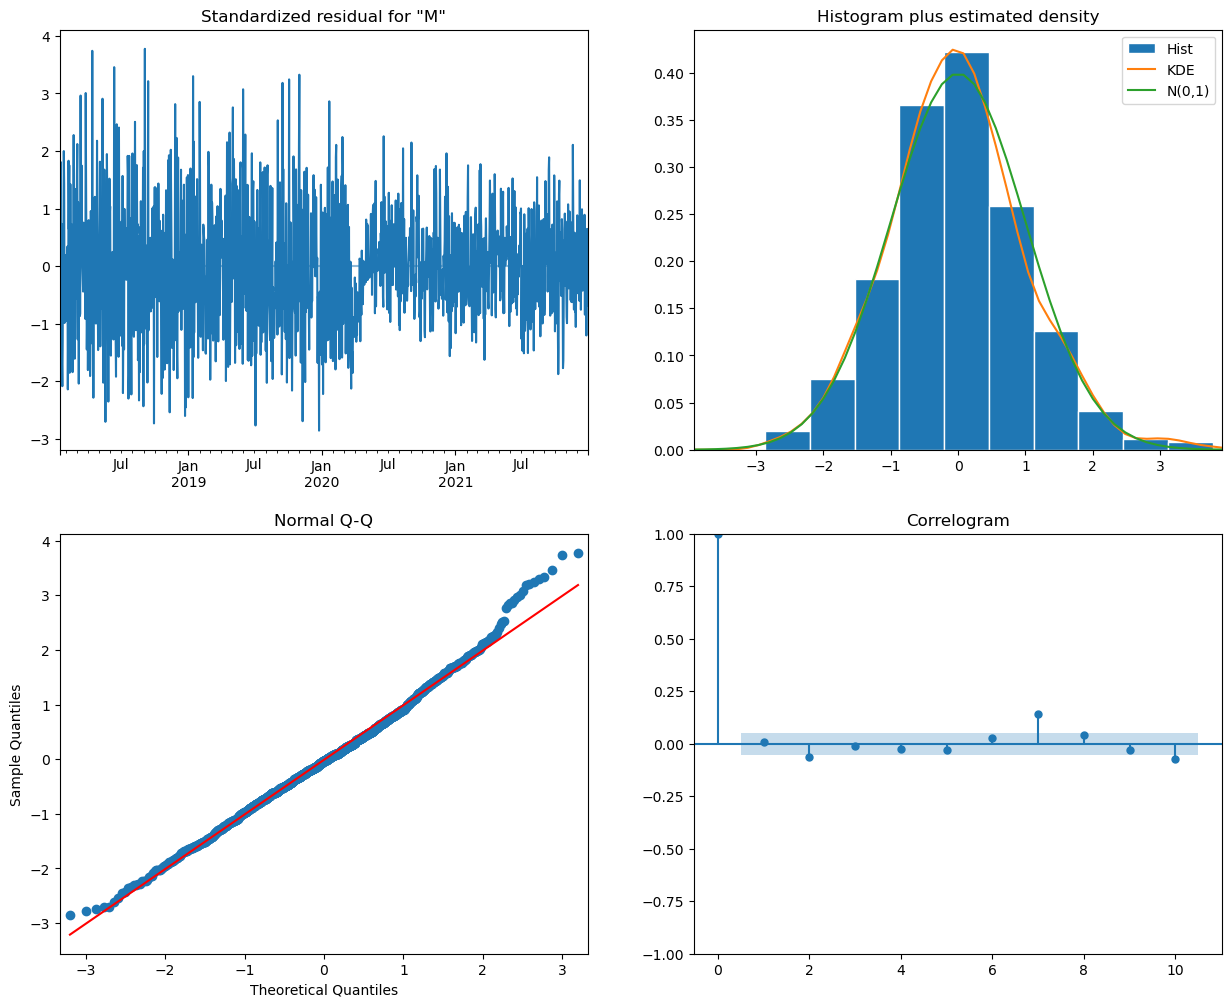

In [49]:
model3.plot_diagnostics(figsize=(15,12));


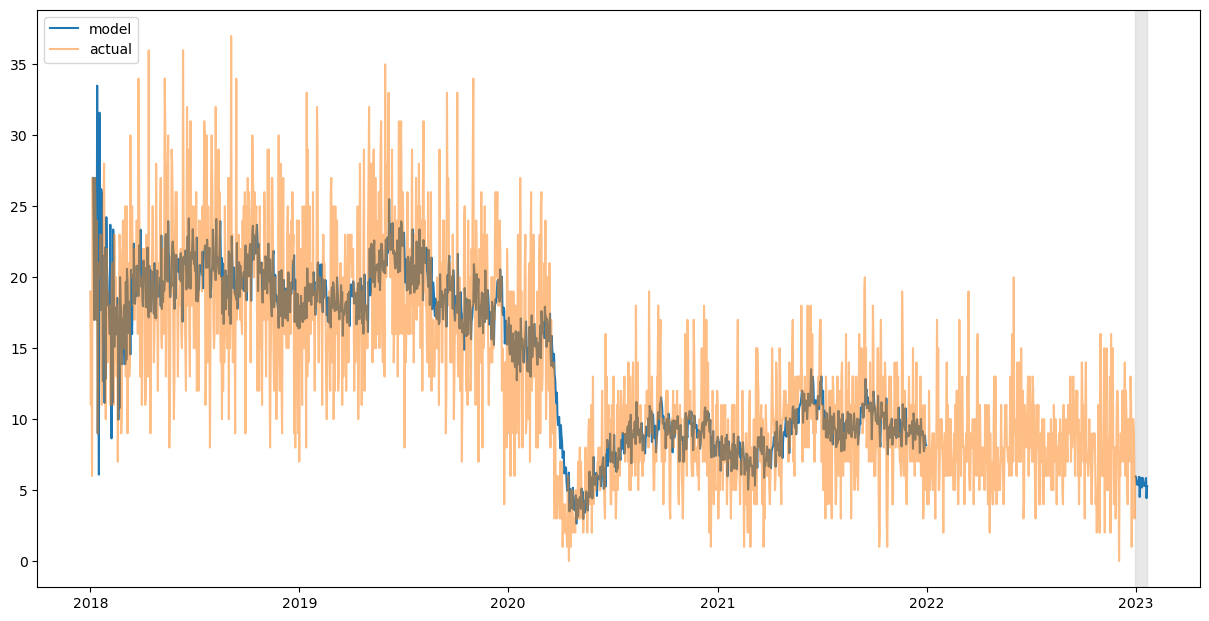

In [50]:
ts_mv['arima_model'] = model3.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast = model3.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast = ts_mv['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, label='model')
plt.axvspan(ts_mv.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
#plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.legend()
plt.show()

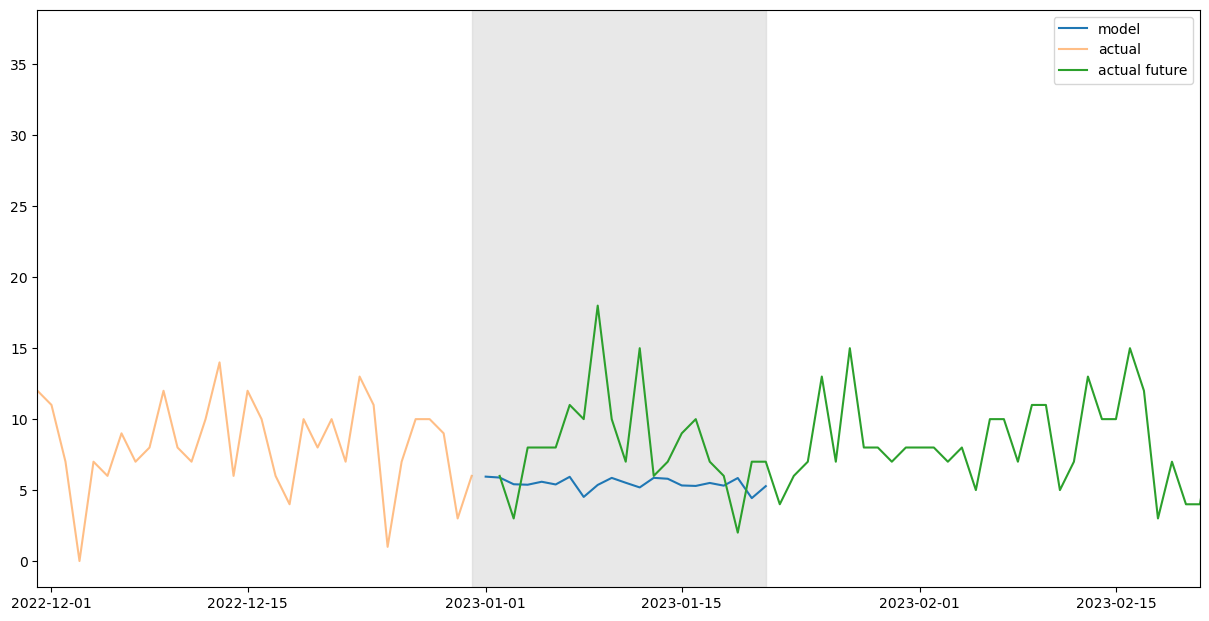

In [51]:
#Closer look

ts_mv['arima_model'] = model3.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast = model3.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast = ts_mv['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, label='model')
plt.axvspan(ts_mv.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.xlim(ts_mv.index[-1] - pd.DateOffset(months=1), forecast.index[-1] + pd.DateOffset(months=1))
plt.legend()
plt.show();

In [52]:
train3_pred = forecast.dropna()
train3_pred = train3_pred[:'2023-01-05']
train3_pred


2018-01-06    26.999283
2018-01-07    22.000106
2018-01-08    17.000192
2018-01-09    23.999767
2018-01-10    26.999869
                ...    
2023-01-01     5.947777
2023-01-02     5.882983
2023-01-03     5.410685
2023-01-04     5.377865
2023-01-05     5.587254
Length: 1461, dtype: float64

In [53]:
#
rmse_model3 = np.sqrt(mean_squared_error(train, train3_pred))

print(f'Third Model RMSE: {rmse_model3}')

Third Model RMSE: 4.725217229656948


In [54]:
print(f'Baseline Model RMSE: {baseline_rmse}')
print(f'First Model RMSE: {rmse_model1}')
print(f'Second Model RMSE: {rmse_model2}')
print(f'Third Model RMSE: {rmse_model3}')

Baseline Model RMSE: 6.167912992652499
First Model RMSE: 4.777718879261387
Second Model RMSE: 5.22860326224159
Third Model RMSE: 4.725217229656948


# Fourth Model

In [55]:
#m = 7 to signify daily data
params3 = optimize_SARIMA(parameters_list, 1, 1, 7, train['Moving Violation'])
params3

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 1)",8507.155753
1,"(1, 1, 0, 1)",8507.536179
2,"(1, 3, 0, 1)",8508.143498
3,"(2, 2, 0, 1)",8508.241161
4,"(1, 2, 0, 1)",8508.524518
...,...,...
251,"(3, 0, 0, 0)",9630.272187
252,"(2, 0, 0, 0)",9714.150184
253,"(0, 0, 1, 0)",9769.137891
254,"(1, 0, 0, 0)",9908.781689


In [56]:
model4 = SARIMAX(train['Moving Violation'], order=(0, 1, 2), seasonal_order=(0, 1, 1, 7)).fit(dis=-1)
model4.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04778D+00    |proj g|=  6.93186D-02

At iterate    5    f=  2.91165D+00    |proj g|=  7.12880D-03


 This problem is unconstrained.



At iterate   10    f=  2.90868D+00    |proj g|=  7.14230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   9.229D-06   2.909D+00
  F =   2.9086775334205326     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    Moving Violation   No. Observations:                 1461
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -4249.578
Date:                             Sun, 16 Apr 2023   AIC                           8507.156
Time:                                     01:30:30   BIC                           8528.281
Sample:                                 01-01-2018   HQIC                          8515.038
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8356      0.024    -35.050      0.000      -0.882      -0.789
ma.L2         -0.0782      0.024     -3.241      0.001      -0.125      -0.031
ma.S.L7       -0.9657      0.009   -107.863      0.000      -0.983      -0.948
sigma2        20.0099      0.687     29.115      0.000      18.663      21.357
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.45
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

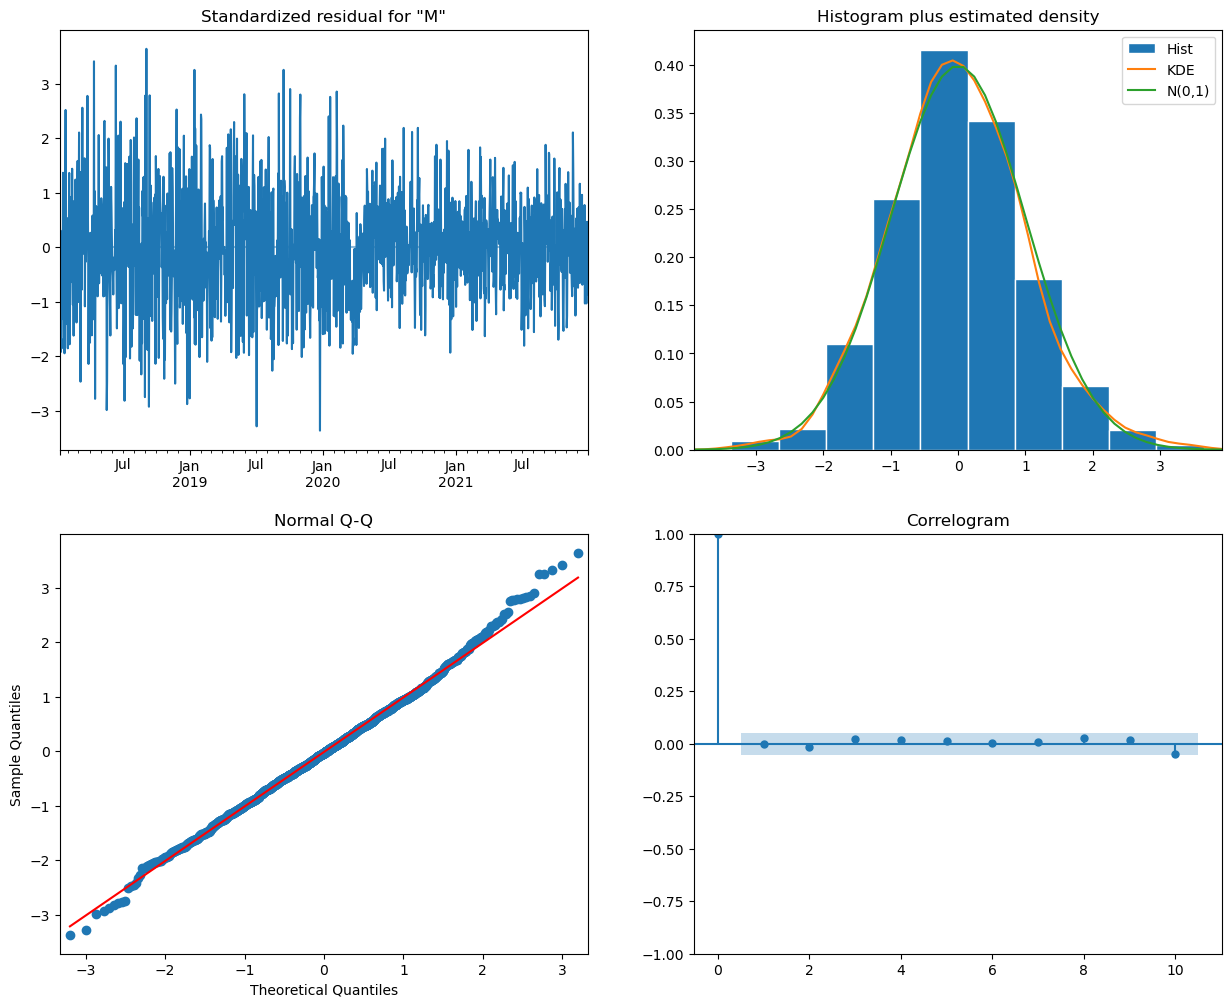

In [57]:
model4.plot_diagnostics(figsize=(15,12));


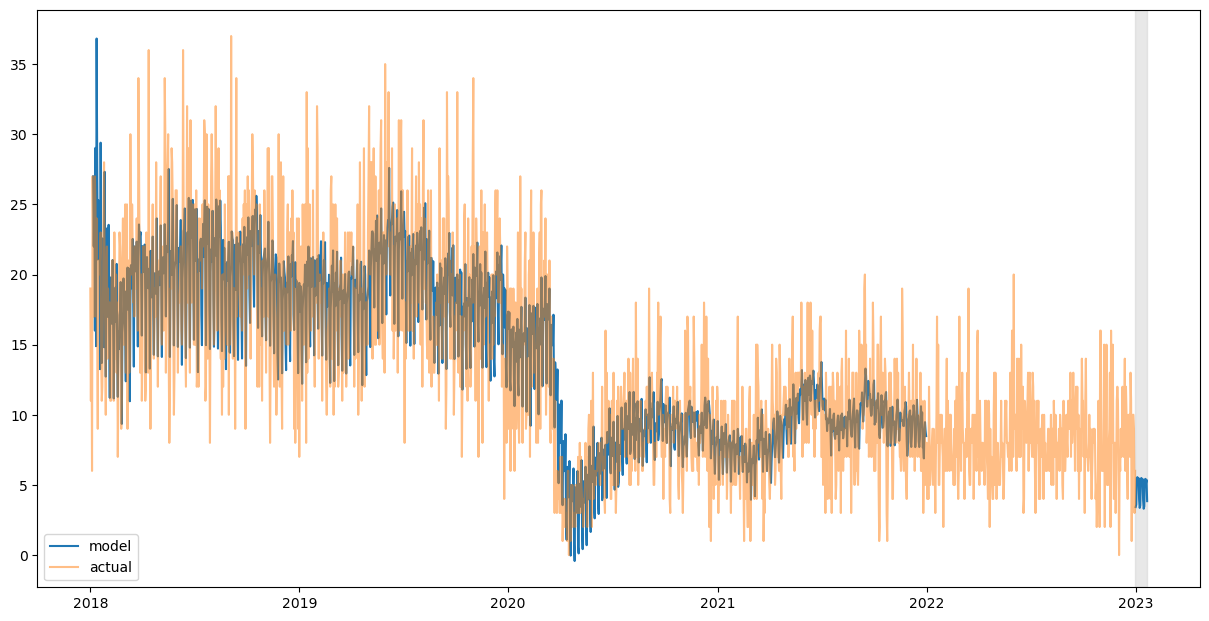

In [58]:
ts_mv['arima_model'] = model4.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast = model4.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast = ts_mv['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, label='model')
plt.axvspan(ts_mv.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
#plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.legend()
plt.show()

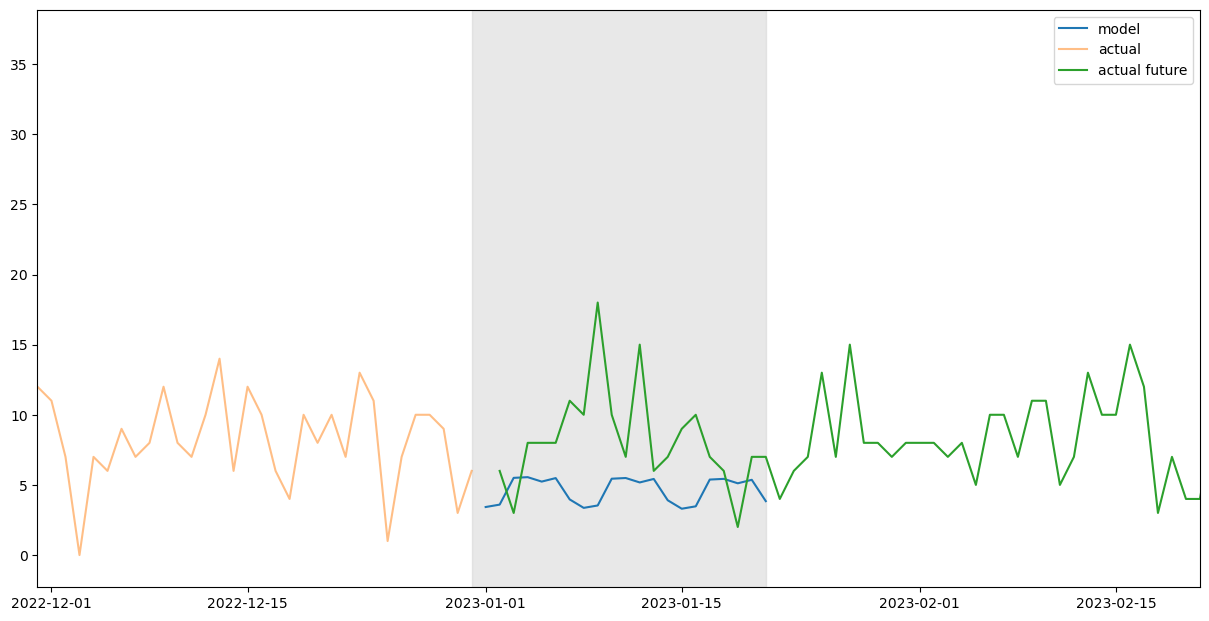

In [59]:
#Closer look

ts_mv['arima_model'] = model4.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast = model4.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast = ts_mv['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, label='model')
plt.axvspan(ts_mv.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.xlim(ts_mv.index[-1] - pd.DateOffset(months=1), forecast.index[-1] + pd.DateOffset(months=1))
plt.legend()
plt.show();

In [60]:
train4_pred = forecast.dropna()
train4_pred = train3_pred[:'2023-01-05']
train4_pred


2018-01-06    26.999283
2018-01-07    22.000106
2018-01-08    17.000192
2018-01-09    23.999767
2018-01-10    26.999869
                ...    
2023-01-01     5.947777
2023-01-02     5.882983
2023-01-03     5.410685
2023-01-04     5.377865
2023-01-05     5.587254
Length: 1461, dtype: float64

In [61]:
#
rmse_model4 = np.sqrt(mean_squared_error(train, train4_pred))

print(f'Fourth Model RMSE: {rmse_model4}')

Fourth Model RMSE: 4.725217229656948


In [62]:
print(f'Baseline Model RMSE: {baseline_rmse}')
print(f'First Model RMSE: {rmse_model1}')
print(f'Second Model RMSE: {rmse_model2}')
print(f'Third Model RMSE: {rmse_model3}')
print(f'Fourth Model RMSE: {rmse_model4}')

Baseline Model RMSE: 6.167912992652499
First Model RMSE: 4.777718879261387
Second Model RMSE: 5.22860326224159
Third Model RMSE: 4.725217229656948
Fourth Model RMSE: 4.725217229656948


In [131]:
start=len(train)
end=len(train)+len(test)-1
pred4 = model4.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(0,1,1,12) Predictions')

In [132]:
# Compare predictions to expected values
for i in range(len(pred4)):
    print(f"predicted={pred4[i]:<11.10}, expected={test['Moving Violation'][i]}")
     

predicted=7.158490996, expected=8.0
predicted=6.592678043, expected=4.0
predicted=6.763692446, expected=7.0
predicted=8.671411249, expected=4.0
predicted=8.721125825, expected=12.0
predicted=8.405247416, expected=8.0
predicted=8.654293938, expected=5.0
predicted=7.133908002, expected=6.0
predicted=6.531754151, expected=7.0
predicted=6.702768554, expected=8.0
predicted=8.610487357, expected=9.0
predicted=8.660201933, expected=5.0
predicted=8.344323524, expected=9.0
predicted=8.593370045, expected=6.0
predicted=7.07298411 , expected=6.0
predicted=6.470830259, expected=3.0
predicted=6.641844662, expected=7.0
predicted=8.549563464, expected=10.0
predicted=8.599278041, expected=17.0
predicted=8.283399632, expected=8.0
predicted=8.532446153, expected=15.0
predicted=7.012060218, expected=5.0
predicted=6.409906367, expected=5.0
predicted=6.58092077 , expected=8.0
predicted=8.488639572, expected=10.0
predicted=8.538354149, expected=8.0
predicted=8.22247574 , expected=10.0
predicted=8.471522261,

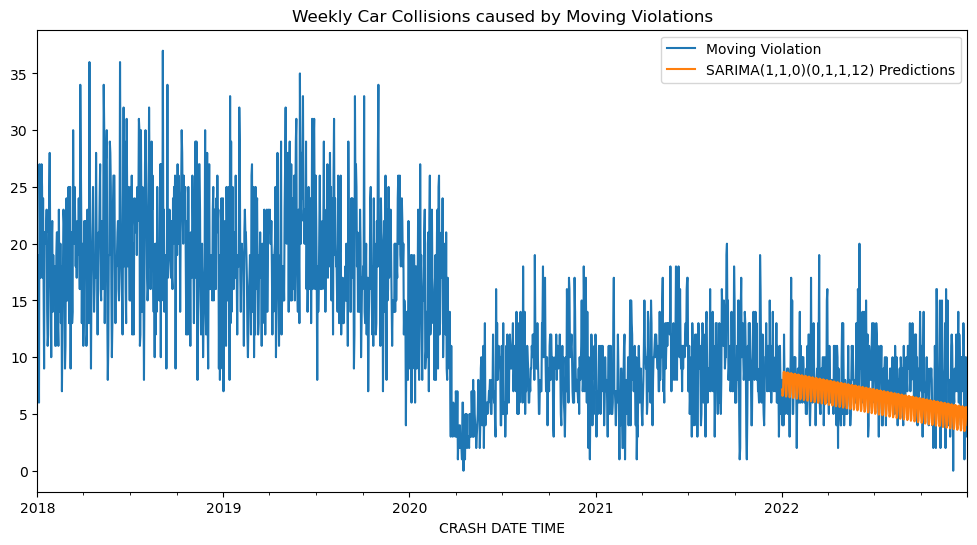

In [133]:
# Plot predictions against known values
title = 'Weekly Car Collisions caused by Moving Violations'
ax = ts_mv['Moving Violation'].plot(legend=True,figsize=(12,6),title=title)
pred4.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

In [136]:
start=len(train)
end=len(train)+len(test)-1
pred3 = model3.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,2)(0,1,2,53) Predictions')

In [137]:
# Compare predictions to expected values
for i in range(len(pred3)):
    print(f"predicted={pred3[i]:<11.10}, expected={test['Moving Violation'][i]}")
     

predicted=7.111552233, expected=8.0
predicted=7.642520217, expected=4.0
predicted=8.664895581, expected=7.0
predicted=7.950525125, expected=4.0
predicted=7.945692161, expected=12.0
predicted=8.529954328, expected=8.0
predicted=8.808163331, expected=5.0
predicted=8.094536897, expected=6.0
predicted=7.711929519, expected=7.0
predicted=8.14437539 , expected=8.0
predicted=8.148765003, expected=9.0
predicted=8.516032275, expected=5.0
predicted=7.062212604, expected=9.0
predicted=7.929384002, expected=6.0
predicted=8.389590903, expected=6.0
predicted=8.071893112, expected=3.0
predicted=7.719839517, expected=7.0
predicted=8.402491822, expected=10.0
predicted=8.313858521, expected=17.0
predicted=7.858333443, expected=8.0
predicted=7.849823617, expected=15.0
predicted=8.043710453, expected=5.0
predicted=7.839291446, expected=5.0
predicted=8.389536747, expected=8.0
predicted=6.975011089, expected=10.0
predicted=7.818815954, expected=8.0
predicted=8.318094226, expected=10.0
predicted=7.972827217,

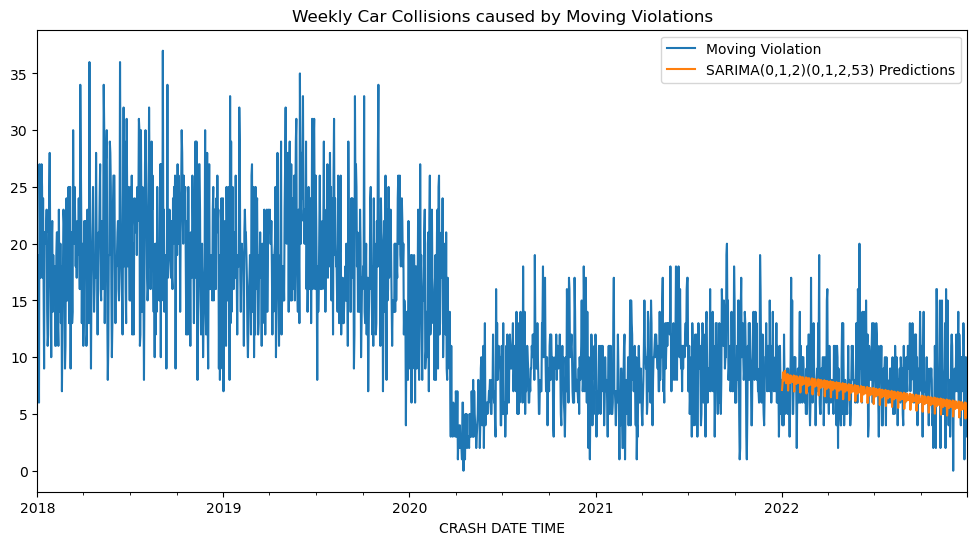

In [139]:
# Plot predictions against known values
title = 'Weekly Car Collisions caused by Moving Violations'
ax = ts_mv['Moving Violation'].plot(legend=True,figsize=(12,6),title=title)
pred3.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);